In [ ]:
from __future__ import division, print_function
import numpy as np
from skimage.util import img_as_float
from .inner import inner_ialm
from .jacobian import framed_gradient, warp_image_gradient
from .tform import AffineTransform

def rasl(Image, InitT=None, maxiter=1000, stop_delta=0.01,
         normalize=True, show=None):
    """Batch image alignment: RASL main loop

    Parameters
    ----------
    Image : array(nimages) of ndarray
        array of raw images as ndarray(h, v)
    InitT : array(nimages) of TForm or None
        initial transforms. Each may include an inset frame as well as
        initial paramv value. Its ttype will be used for the alignment.
        Default is an AffineTransform with a 5-pixel inset
    maxiter : integer
        maximum interations to convergence
    stop_delta : real
        stop iterating when objective change is less than this
    normalize : bool
        if True, normalize transformed images and their gradients
    show : tuple or None
        Display intermediate image alignments.

    Returns
    -------
    L : array(nimages) of ndarray(h, v)
        aligned low-rank images
    S : array(nimages) of ndarray(h, v)
        aligned sparse error images
    T : array(nimages) of TForm
        final transforms. Each will include initT's inset frame and
        the aligning paramv
    iter : int
        number of iterations to convergence

    """
    if InitT is None:
        T = [AffineTransform().inset(image.shape, 5) for image in Image]
    else:
        T = [tform.clone() for tform in InitT]
    Image = [img_as_float(image) for image in Image]
    Image_x, Image_y = zip(*[framed_gradient(tform, image)
                             for tform, image in zip(T, Image)])
    shape = T[0].output_shape
    lambd = 1 / np.sqrt(np.prod(shape))
    prev_obj = np.inf

    if show:
        from .show import show_vec_images, show_images
        show_images([tform.imtransform(image)
                     for tform, image in zip(T, Image)], show, title="Original")

    itr = 0
    while itr < maxiter:
        itr = itr + 1
        TImage, J = zip(*[
            warp_image_gradient(tf, im, ix, iy, normalize=normalize)
            for tf, im, ix, iy in zip(T, Image, Image_x, Image_y)])
        A, E, dParamv = inner_ialm(TImage, J)

        # take the step in parameter space
        for tform, dparamv in zip(T, dParamv):
            tform.paramv = tform.paramv + dparamv

        # how are we doing?
        objective = np.linalg.norm(A, 'nuc') + lambd * np.abs(E).sum()
        if show:
            _show_outer(A, E, shape, show)
            print("[{}] objective {} delta{}".format(
                itr, objective, prev_obj-objective))

        if (prev_obj - objective) < stop_delta:
            break

        prev_obj = objective

    Norm = [np.sqrt(np.linalg.norm(image, 'fro')) for image in Image]
    L = [A[:, i].reshape(shape) * norm for i, norm in enumerate(Norm)]
    S = [E[:, i].reshape(shape) * norm for i, norm in enumerate(Norm)]
    return L, S, T, itr

def _show_outer(A, E, shape, show_shape):
    from .show import show_vec_images, show_images
    show_vec_images(A[:, :show_shape[0] * show_shape[1]], shape, show_shape,
                    title="Aligned")
    show_vec_images(E[:, :show_shape[0] * show_shape[1]], shape, show_shape,
                    title="Errors")


In [75]:
from skimage import io
from skimage.util import img_as_float
from rasl import rasl
import time
from rasl.tform import SimilarityTransform
import os
images = [img_as_float(io.imread(os.path.join("good_cropped", f), as_grey=True)) 
          for f in os.listdir("good_cropped") if f.endswith("png")]
print len(images)
# T = [SimilarityTransform.inset(image.shape, 5) for image in images]
L, S, T, it = rasl(images, show=(3,1))

print type(L)
print type(S)
print type(T)
print type(it)




3


NameError: global name 'time' is not defined

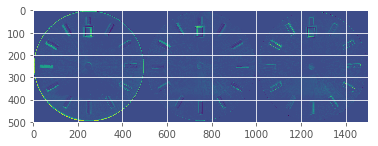

In [72]:
import matplotlib.pyplot as plt
import numpy as np

first = S[0]
middle = S[1]
last = S[2]
# jigo = np.hstack(L)
plt.imshow(np.hstack([first , middle,  last]))
plt.show()